In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re, io
import spacy
import string

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import gensim
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from gensim.models import TfidfModel

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st
from scattertext import CorpusFromPandas, produce_scattertext_explorer
from collections import Counter

import pyLDAvis
import pyLDAvis.gensim_models 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

from pprint import pprint
from scipy.stats import rankdata, hmean, norm

import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\anne\AppData\Local\Temp\ipykernel_17156\156370638.py:42: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
twcs_df = pd.read_csv('twcs/twcs.csv')

In [3]:
twcs_df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [4]:
twcs_df.shape

(2811774, 7)

In [5]:
twcs_df['author_id'].nunique()

702777

In [6]:
# Let us clean the tweet text for better visualization
twcs_df = twcs_df[~twcs_df['text'].isnull()]

def preprocess(CleanText):
    CleanText = CleanText.str.replace("(<br/>)", "", regex=True)
    CleanText = CleanText.str.replace('(<a).*(>).*(</a>)', '', regex=True)
    CleanText = CleanText.str.replace('(&amp)', '', regex=True)
    CleanText = CleanText.str.replace('(&gt)', '', regex=True)
    CleanText = CleanText.str.replace('(&lt)', '', regex=True)
    CleanText = CleanText.str.replace('(\xa0)', ' ', regex=True)  
    CleanText = CleanText.str.replace('[^\\w\\s]','', regex=True) 
    CleanText = CleanText.str.lower() 
    return CleanText

twcs_df['text'] = preprocess(twcs_df['text'])

In [7]:
twcs_df['word_count'] = twcs_df['text'].apply(lambda x: len(str(x).split(" ")))
twcs_df[['text','word_count']].head(5)

,text,word_count
0,115712 i understand i would like to assist you...,23
1,sprintcare and how do you propose we do that,9
2,sprintcare i have sent several private message...,14
3,115712 please send us a private message so tha...,23
4,sprintcare i did,3


<AxesSubplot:>

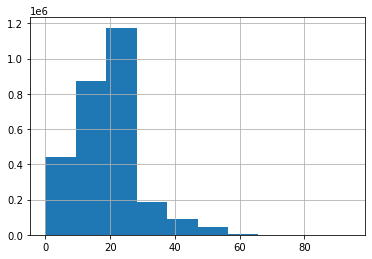

In [8]:
# Let us take a look at distribution of words in each tweet
twcs_df.text.str.split().\
    map(lambda x: len(x)).\
    hist()

In [9]:
# Finding the number of characters in each tweet incuding the spaces
twcs_df['char_count'] = twcs_df['text'].str.len() 
twcs_df[['text','char_count']].head()

,text,char_count
0,115712 i understand i would like to assist you...,117
1,sprintcare and how do you propose we do that,44
2,sprintcare i have sent several private message...,81
3,115712 please send us a private message so tha...,119
4,sprintcare i did,16


<AxesSubplot:>

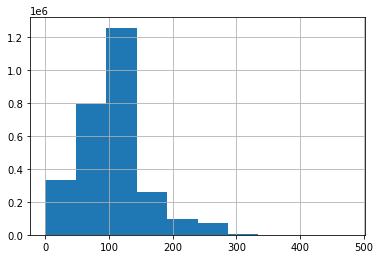

In [10]:
# Plotting the character count for the tweets
twcs_df.text.str.len().hist()

In [11]:
# Let us take a look at the number of stopwords in the tweets
stopword = stopwords.words('english')

twcs_df['stopwords'] = twcs_df['text'].apply(lambda x: len([x for x in x.split() if x in stopword]))
twcs_df[['text','stopwords']].head()

,text,stopwords
0,115712 i understand i would like to assist you...,11
1,sprintcare and how do you propose we do that,7
2,sprintcare i have sent several private message...,6
3,115712 please send us a private message so tha...,12
4,sprintcare i did,2


<AxesSubplot:>

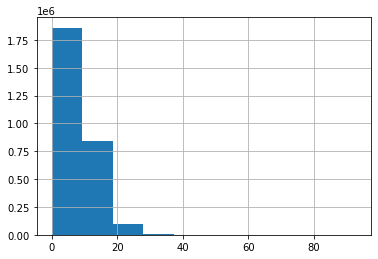

In [12]:
# Distribution of stopwords
twcs_df.text.map(lambda x: len([x for x in x.split() if x in stopword])).hist()

In [13]:
# Removing stopwords from the tweets
twcs_df['text'] = twcs_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stopword))
twcs_df['text'].head()

0    115712 understand would like assist would need...
1                                   sprintcare propose
2    sprintcare sent several private messages one r...
3    115712 please send us private message assist c...
4                                           sprintcare
Name: text, dtype: object

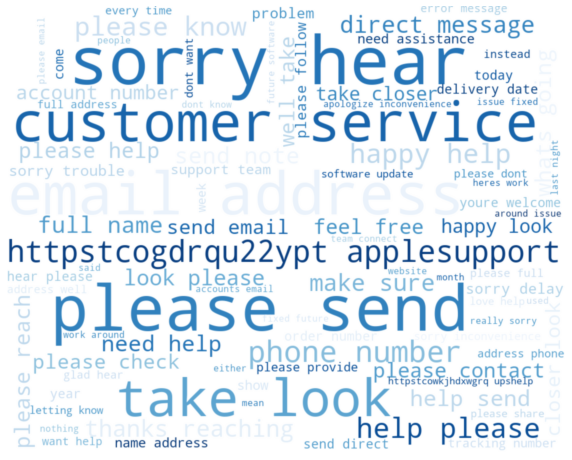

In [14]:
# Let us take a look at the most frequently used word in the tweets
word_cloud = WordCloud(width = 1000,
                       height = 800,
                       colormap = 'Blues', 
                       margin = 0,
                       max_words = 200,  
                       min_word_length = 4,
                       max_font_size = 120, min_font_size = 15,  
                       background_color = "white").generate(" ".join(twcs_df['text']))

plt.figure(figsize = (10, 15))
plt.imshow(word_cloud, interpolation = "gaussian")
plt.axis("off")
plt.show()

In [15]:
print("Word Count of tweets for each Twitter Account")
twcs_df.groupby('author_id').apply(lambda x: x.text.apply(lambda x: len(x.split())).sum())

Word Count of tweets for each Twitter Account


author_id
10026                  34
100363                 13
10103                  19
10221                   3
10286                   8
                    ...  
mediatemplehelp      3692
nationalrailenq     40188
sainsburys         233703
sizehelpteam        14523
sprintcare         258528
Length: 702777, dtype: int64

In [16]:
print("Count of tweets for each Twitter Account")
print(twcs_df.groupby('author_id')['text'].count())

Count of tweets for each Twitter Account
author_id
10026                  3
100363                 1
10103                  2
10221                  2
10286                  1
                   ...  
mediatemplehelp      305
nationalrailenq     4444
sainsburys         19466
sizehelpteam        1482
sprintcare         22381
Name: text, Length: 702777, dtype: int64


In [17]:
# Defining a function to visualise n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

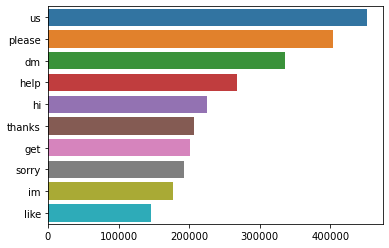

In [18]:
# Visualising the most frequent unigrams in the tweets
top_unigrams = get_top_ngram(twcs_df['text'],1)[:10]
x,y = map(list,zip(*top_unigrams))
sns.barplot(x = y,y = x)

<AxesSubplot:>

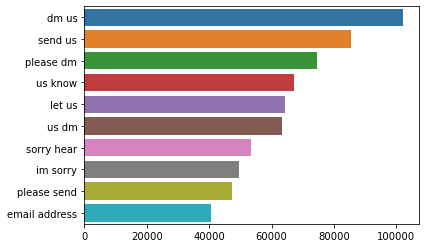

In [19]:
# Visualising the most frequent bigrams in the tweets
top_bigrams = get_top_ngram(twcs_df['text'],2)[:10]
x,y = map(list,zip(*top_bigrams))
sns.barplot(x = y,y = x)

<AxesSubplot:>

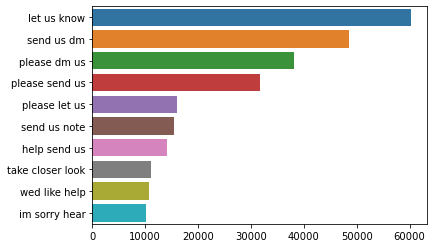

In [20]:
# Visualising the most frequent trigrams in the tweets
top_trigrams = get_top_ngram(twcs_df['text'],3)[:10]
x,y = map(list,zip(*top_trigrams))
sns.barplot(x = y,y = x)

In [22]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\anne\AppData\Roaming\nltk_data...


True

In [23]:
# Pre processing the tweets by performing stemming and lemmatization using nltk
def preprocess_tweets(twcs_df):
    corpus = []
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for tweets in twcs_df['text']:
        words = [w for w in word_tokenize(tweets) if (w not in stopword)]
        
        words = [lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_tweets(twcs_df)

In [24]:
type(corpus)

list

In [25]:
corpus_sentence = [[' '.join(i)] for i in corpus]

In [26]:
corpus_df = pd.DataFrame(corpus_sentence, columns=['data teks'])

In [28]:
corpus_df.head()

,data teks
0,115712 understand would like assist would need...
1,sprintcare propose
2,sprintcare sent several private message one re...
3,115712 please send private message assist clic...
4,sprintcare


In [29]:
corpus_df.shape

(2811774, 1)

In [30]:
corpus_df.to_csv('data_cs_clean.csv')